In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import pickle
import seaborn as sns

churn = 3

### Loading model

In [2]:
with open(f'../../../src/models/Churn{churn}-Hyperotimization-f1-Dummies.md', 'rb') as file:
    rf = pickle.load(file)

Checking Feature importances

In [3]:
with open(f'../../../src/models/Churn{churn}-Hyperotimization-f1-Dummies-TRAINING-COLUMNS.md', 'rb') as file:
    columns = pickle.load(file)

In [4]:
fi = pd.DataFrame(rf.feature_importances_,index=columns, columns=['importance'])

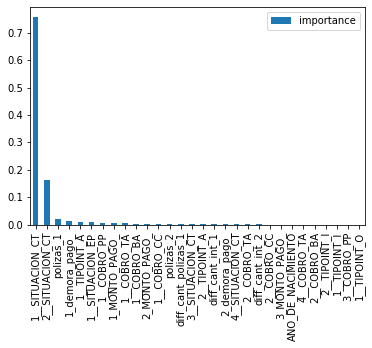

In [5]:
fi.sort_values('importance', ascending=False).iloc[0:30].plot.bar()

In [6]:
top_features = fi.sort_values('importance', ascending=False).iloc[0:30].index

In [7]:
top_features

Index(['1__SITUACION_CT', '2__SITUACION_CT', 'polizas_1', '1_demora_pago_',
       '1__TIPOINT_A', '1__SITUACION_EP', '1__COBRO_PP', '1_MONTO_PAGO_',
       '1__COBRO_TA', '1__COBRO_BA', '2_MONTO_PAGO_', '1__COBRO_CC',
       'polizas_2', 'diff_cant_polizas_1', '3__SITUACION_CT', '2__TIPOINT_A',
       'diff_cant_int_1', '2_demora_pago_', '4__SITUACION_CT', '2__COBRO_TA',
       'diff_cant_int_2', '2__COBRO_CC', '3_MONTO_PAGO_', 'ANO_DE_NACIMIENTO',
       '4__COBRO_TA', '2__COBRO_BA', '2__TIPOINT_I', '1__TIPOINT_I',
       '3__COBRO_PP', '1__TIPOINT_O'],
      dtype='object')

### Retrain model with 20 features

In [8]:
df_train = pd.read_feather(f"../../../data/processed/Churn_{churn}_train_set.feather")

In [9]:
df_opt = pd.read_feather(f"../../../data/processed/Churn_{churn}_optimization_set.feather")

In [10]:
X_train = df_train.drop([f"BAJA_{churn}m", "DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window","index"], axis=1)
y_train = df_train[f"BAJA_{churn}m"]
del df_train

In [11]:
X_opt = df_opt.drop([f"BAJA_{churn}m", "DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window","index"], axis=1)
y_opt = df_opt[f"BAJA_{churn}m"]
del df_opt

### Feature Eng

Dummifying

In [12]:
X_train = pd.get_dummies(X_train)
X_train = X_train.fillna(-999)

Filtering top 20 columns

In [13]:
X_train = X_train[top_features]

In [14]:
X_train.head()

,1__SITUACION_CT,2__SITUACION_CT,polizas_1,1_demora_pago_,1__TIPOINT_A,1__SITUACION_EP,1__COBRO_PP,1_MONTO_PAGO_,1__COBRO_TA,1__COBRO_BA,...,diff_cant_int_2,2__COBRO_CC,3_MONTO_PAGO_,ANO_DE_NACIMIENTO,4__COBRO_TA,2__COBRO_BA,2__TIPOINT_I,1__TIPOINT_I,3__COBRO_PP,1__TIPOINT_O
0,1.0,1.0,1.0,0.0,0.0,-999.0,-999.0,3537.0,1.0,-999.0,...,-1.0,-999.0,3537.0,1953.0,1.0,-999.0,0.0,0.0,-999.0,2.0
1,1.0,1.0,1.0,0.0,0.0,-999.0,-999.0,4484.0,1.0,-999.0,...,0.0,-999.0,4307.0,1954.0,1.0,-999.0,0.0,0.0,-999.0,4.0
2,1.0,1.0,1.0,0.0,0.0,-999.0,-999.0,2658.0,-999.0,-999.0,...,-5.0,1.0,2658.0,1956.0,-999.0,-999.0,2.0,3.0,-999.0,4.0
3,1.0,1.0,1.0,0.0,0.0,-999.0,-999.0,686.0,-999.0,-999.0,...,1.0,1.0,653.0,1931.0,-999.0,-999.0,0.0,1.0,-999.0,3.0
4,1.0,1.0,1.0,0.0,0.0,-999.0,-999.0,1490.0,1.0,-999.0,...,-2.0,-999.0,1258.0,1964.0,1.0,-999.0,0.0,0.0,-999.0,2.0


In [15]:
X_opt = pd.get_dummies(X_opt)
X_opt = X_opt.fillna(-999)
for col in [col for col in X_train.columns if col not in X_opt.columns]:
    X_opt[col] = -999
X_opt = X_opt.drop([col for col in X_opt.columns if col not in X_train.columns], axis=1)

In [16]:
len(X_opt.columns) 

30

In [17]:
len(X_train.columns)

30

### Optimization

In [18]:
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.metrics import f1_score, roc_auc_score 
from numpy.random import RandomState
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tqdm import tqdm_notebook as tqdm

In [19]:
from sklearn.utils.class_weight import compute_class_weight 

In [20]:
compute_class_weight("balanced", y_train.unique(), y_train)

array([ 0.51064318, 23.98922618])

In [21]:
space = {
    "algo": hp.choice("algo", [RandomForestClassifier, ExtraTreesClassifier]),
    "params": {
        "n_estimators": hp.choice("n_estimators", [40, 80, 100]),  # 100, 400
        "min_samples_leaf": hp.choice("min_samples_leaf", [5, 20, 35, 55]), # , 65
        "max_depth": hp.choice("max_depth", [5, 10, 15]), # 10,
        "max_features": hp.choice("max_features", ['sqrt', 0.5, None]),
        "class_weight": hp.choice("class_weight", [{0:1, 1:30}, {0:1, 1:40},  {0:1, 1:50}]) ,
    }
}

In [22]:
evals = 60
pbar = tqdm(total=evals)

def __optimizerFunc(args):
    pbar.update(0.5)
    args["params"]["verbose"] = 1
    args["params"]["n_jobs"] = -1
    args["params"]["random_state"] = 42
    model = args["algo"](**args["params"])
    print(f"Trying: {model}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_opt) 
    pbar.update(0.5)
    # greater is better
    return {"loss": -f1_score(y_opt, y_pred), "status": STATUS_OK,}
          
trials = Trials()
__bestClassifier = fmin(fn=__optimizerFunc,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=evals,
                        trials=trials,
                        rstate=RandomState(42)
                        )
pbar.close()

Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=10, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 50},
            criterion='gini', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   39.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=15, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=15, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=15, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   46.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 50},
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=15, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=10, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   39.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   46.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=5, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=10, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 50},
            criterion='gini', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=5, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=10, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   30.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 50},
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=35,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 50},
            criterion='gini', max_depth=10, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=5, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 50},
           criterion='gini', max_depth=10, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.4s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=15, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=42,
           verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.5s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 50},
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


In [31]:
print(trials.results)

[{'loss': -0.04160020247296753, 'status': 'ok'}, {'loss': -0.04160312206557137, 'status': 'ok'}, {'loss': -0.041514609144371356, 'status': 'ok'}, {'loss': -0.04160020247296753, 'status': 'ok'}, {'loss': -0.041559722935180426, 'status': 'ok'}, {'loss': -0.041495292327523775, 'status': 'ok'}, {'loss': -0.025753768844221106, 'status': 'ok'}, {'loss': -0.04134910381342494, 'status': 'ok'}, {'loss': -0.01910129535228398, 'status': 'ok'}, {'loss': -0.04154799131595195, 'status': 'ok'}, {'loss': -0.041555734080482284, 'status': 'ok'}, {'loss': -0.0415787027816504, 'status': 'ok'}, {'loss': -0.04190333407158799, 'status': 'ok'}, {'loss': -0.041523456568735864, 'status': 'ok'}, {'loss': -0.04028524204336296, 'status': 'ok'}, {'loss': -0.03807677234380479, 'status': 'ok'}, {'loss': -0.03946740479144793, 'status': 'ok'}, {'loss': -0.04137032085561498, 'status': 'ok'}, {'loss': -0.0415787027816504, 'status': 'ok'}, {'loss': -0.04157717040199454, 'status': 'ok'}, {'loss': -0.04146118417770979, 'sta

In [32]:
print("Best Config:")
opt_config = space_eval(space, __bestClassifier)
print(opt_config)

Best Config:
{'algo': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'params': {'class_weight': {0: 1, 1: 30}, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 35, 'n_estimators': 80}}


In [33]:
rf_min = opt_config['algo'](**opt_config['params'])

In [ ]:
rf_min.fit(X_train, y_train)

### Metrics

In [39]:
df_val = pd.read_feather(f"../../../data/processed/Churn_{churn}_validation_set.feather")

In [40]:
X_val = df_val.drop([f"BAJA_{churn}m", "DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window","index"], axis=1)
y_val = df_val[f"BAJA_{churn}m"]
del df_val

In [41]:
X_val = pd.get_dummies(X_val)
X_val = X_val.fillna(-999)
for col in [col for col in X_train.columns if col not in X_val.columns]:
    X_val[col] = -999

In [42]:
X_val = X_val.drop([col for col in X_val.columns if col not in X_train.columns], axis=1)

In [43]:
len(X_val.columns)

20

In [46]:
predictions = rf_min.predict(X_val)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
cmap = sns.color_palette("coolwarm", 7)
sns.set(font_scale=1)
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt="d", linewidths=.5, cmap=cmap) 